<a href="https://colab.research.google.com/github/simon-mellergaard/GAI-with-LLMs/blob/main/Litterature/NLP_06_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://www.kaggle.com/code/simonmellergaard/nlp-06-summarization/edit)

In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements(is_chapter6=True)

Cloning into 'notebooks'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 530 (delta 209), reused 186 (delta 186), pack-reused 289 (from 1)
Receiving objects: 100% (530/530), 34.57 MiB | 31.22 MiB/s, done.
Resolving deltas: 100% (249/249), done.
/kaggle/working/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
#hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v2.0.0


In [1]:
from transformers import pipeline, set_seed

2025-09-17 09:18:19.470052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758100699.788255      76 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758100699.876222      76 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install rouge_score
!pip install evaluate
!pip install sacrebleu

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9d7fa15cc306972cc30b0366eda5ad24abe026fa25a28d85e9912bb0c5ba9f2c
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which 

In [ ]:
# Logging in to Huggingface and wandb
import os
from google.colab import userdata
from huggingface_hub import login as login_hf
from wandb import login as login_wandb
os.environ['HF_TOKEN'] = userdata.get('HF')
os.environ['WANDB_TOKEN'] = userdata.get('wandb')
login_hf(os.environ['HF_TOKEN'])
login_wandb(key = os.environ['WANDB_TOKEN'])

# Logging in to HF from Kaggle
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# from huggingface_hub import login as login_hf
# login_hf(user_secrets.get_secret("HF"))

# Summarization

## The CNN/DailyMail Dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0", trust_remote_code=True)
print(f"Features: {dataset['train'].column_names}")

README.md: 0.00B [00:00, ?B/s]

cnn_dailymail.py: 0.00B [00:00, ?B/s]

cnn_stories.tgz:   0%|          | 0.00/159M [00:00<?, ?B/s]

dailymail_stories.tgz:   0%|          | 0.00/376M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Features: ['article', 'highlights', 'id']


In [ ]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 3192):

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n

Summary (length: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


## Text Summarization Pipelines

In [8]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization Baseline


In [ ]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries["baseline"] = three_sentence_summary(sample_text)

### GPT-2

In [ ]:
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=512) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


### T5

<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_t5.png?raw=1" id="T5"/>

In [ ]:
#hide_output
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Device set to use cuda:0


### BART

In [ ]:
#hide_output
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


### PEGASUS

<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter08_pegasus.png?raw=1" id="pegasus"/>

In [9]:
#hide_output
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.58.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


## Comparing Different Summaries

In [ ]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.

GPT2
- Usain Bolt won the 100m and 200m gold medals, making him the third fastest man in the world
- A third gold at this year's world championships means he is on course to surpass Michael Johnson's record of 10 Olympic medals
- Bolt is now on course to win 10 gold medals.
Michael Johnson now has 5 Olympic medals and h

## Measuring the Quality of Generated Text

### BLEU

In [5]:
# hide_output
# from datasets import load_metric

# bleu_metric = load_metric("sacrebleu")
import evaluate
bleu_metric = evaluate.load("sacrebleu")

In [23]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

In [ ]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


### ROUGE

In [7]:
rouge_metric = evaluate.load("rouge")

In [ ]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.170000,0.050505,0.110000,0.150000
t5,0.486486,0.222222,0.378378,0.486486
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


## Evaluating PEGASUS on the CNN/DailyMail Dataset

In [14]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [ ]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.388019,0.170517,0.24714,0.354912


In [13]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=8, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=2) # REDUCED BATCH SIZE

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 500/500 [46:40<00:00,  5.60s/it]


AttributeError: 'numpy.float64' object has no attribute 'mid'

In [ ]:
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.427037,0.207522,0.30509,0.369171


## Training a Summarization Model

In [5]:
# hide_output
dataset_samsum = load_dataset("knkarthick/samsum")
dataset_samsum["train"] = dataset_samsum["train"].select(
    [i for i in range(len(dataset_samsum["train"])) if i != 6054]
)
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Split lengths: [14731, 818, 819]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### Evaluating PEGASUS on SAMSum

In [10]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


In [ ]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=2) # Reduced batch size

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

  2%|▏         | 7/410 [00:28<26:40,  3.97s/it]

In [ ]:
# hide_input
pd.DataFrame(rouge_dict, index=["pegasus"])

### Fine-Tuning PEGASUS

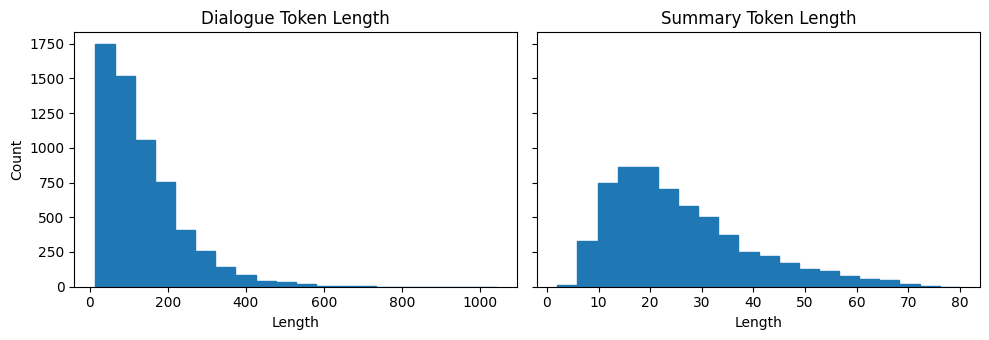

In [20]:
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"][:6055]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"][:6055]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [21]:
#hide_output
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [24]:
#hide_input

#id teacher-forcing
#alt Decoder input and label alignemt for text generation.
#caption Decoder input and label alignemt for text generation.
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [25]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [26]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    eval_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [28]:
# hide_output
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

/tmp/ipykernel_76/4025212638.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


In [29]:
#import torch
torch.cuda.empty_cache()

In [30]:
# hide_output
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: simonmellergaard (simonmellergaard-aarhus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 3803 has 14.74 GiB memory in use. Of the allocated memory 14.18 GiB is allocated by PyTorch, and 358.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# hide_input
pd.DataFrame(rouge_dict, index=[f"pegasus"])

In [ ]:
# hide_output
trainer.push_to_hub("Training complete!")

### Generating Dialogue Summaries

In [ ]:
# hide
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)
print("\nReference Summary:")
print(reference)
print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

In [ ]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

## Conclusion